The python API is not currently stable, but you can render headlessly using `bpy` and `molecularnodes`.

I still can't reliably get GPU rendering to work.

## Setup

Blender's python API is very verbose, and at times unintuitive, so we can create some helper functions for setting up the scene and rendering images.

#### Convenience Functions

In [1]:
#| label: setup
#| code-fold: true
import molecularnodes as mn
import bpy
import sys
import tempfile
import os
from IPython.display import display, Image
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import math
from mathutils import Vector


sys.stdout = open(os.devnull, 'w')
sys.stderr = open(os.devnull, 'w')
# mn.register()

def clear_scene():
    bpy.ops.object.select_all(action="DESELECT")
    bpy.ops.object.select_by_type(type="MESH")
    bpy.ops.object.delete()
    for node in bpy.data.node_groups:
        if node.type == "GEOMETRY":
            bpy.data.node_groups.remove(node)

def orient_camera(object, lens = 85, dof = True, f = 2, zoom = 0, focus = 0):
    object.select_set(True)
    camera = bpy.data.objects['Camera']
    distance = Vector(object.location) - Vector(camera.location)
    camera.data.lens = lens
    camera.data.dof.aperture_fstop = f
    # camera.data.dof.focus_object = object
    bpy.ops.view3d.camera_to_view_selected()
    camera.data.lens = lens + zoom
    camera.data.dof.use_dof = dof
    camera.data.dof.focus_distance = distance.length + focus
    camera.data.dof.focus_distance = 1.2

def render_image(engine = 'eevee', x = 1000, y = 500):
    # setup render engine
    if engine == "eevee":
        bpy.context.scene.render.engine = "BLENDER_EEVEE"
    elif engine == "cycles":
        
        bpy.context.scene.render.engine = "CYCLES"
        try:
            bpy.context.scene.cycles.device = "GPU"
        except:
            print("GPU Rendering not available")
    

    # Render
    with tempfile.TemporaryDirectory() as temp:

        path = os.path.join(temp, "test.png")
        bpy.context.scene.render.resolution_x = x
        bpy.context.scene.render.resolution_y = y
        bpy.context.scene.render.image_settings.file_format = "PNG"
        bpy.context.scene.render.filepath = path
        bpy.ops.render.render(write_still=True)
        display(Image(filename=path))

#### Scene Setup

In [2]:
#| label: setup-scene
#| code-fold: true

# load template scene with nice HDRI lighting
bpy.ops.wm.read_homefile(app_template = "MolecularNodes")

# change the background to a custom color
try:
    world_nodes = bpy.data.worlds['World Shader'].node_tree.nodes
    world_nodes['MN_world_shader'].inputs['BG Color'].default_value = mn.color.random_rgb()
except KeyError:
    print("Oh no, didn't set up the base scene.")

## Rendering
Now with teh scene set up, we can load some molecules and render.

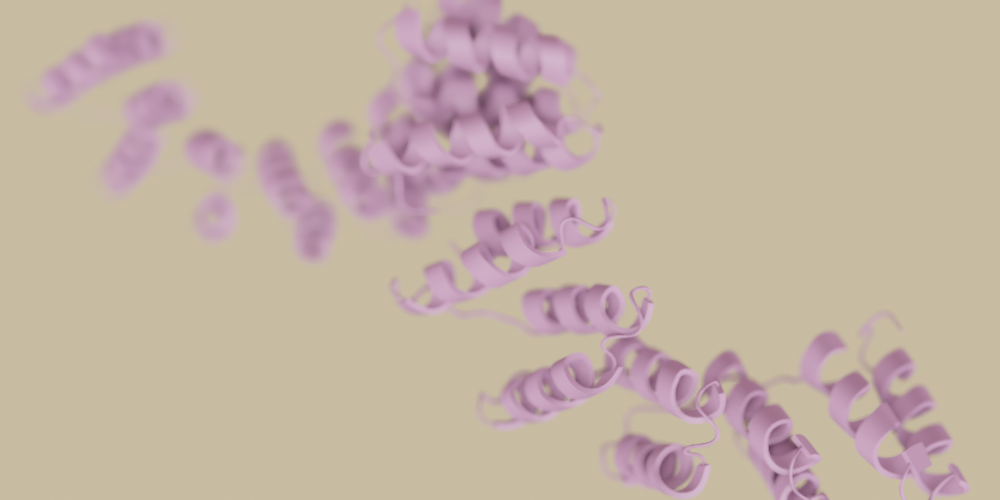

In [3]:
clear_scene()
mol = mn.load.molecule_rcsb('4ozs', build_assembly=True, starting_style="cartoon")
mol.rotation_euler = (0, 3.14 / 2, 0)
mol.select_set(True)
bpy.ops.view3d.camera_to_view_selected()
render_image()

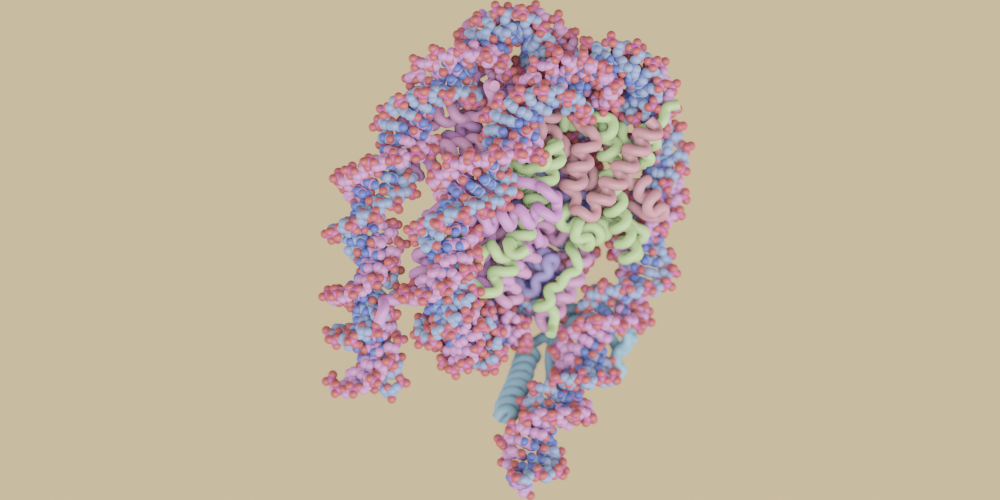

In [10]:
clear_scene()
mol = mn.load.molecule_rcsb('8HXZ', center_molecule = True, starting_style="preset_3")
orient_camera(mol, f = 1)
render_image()

By default, we are using the `EEVEE` rendering enging, but we can also specify `Cycles`.

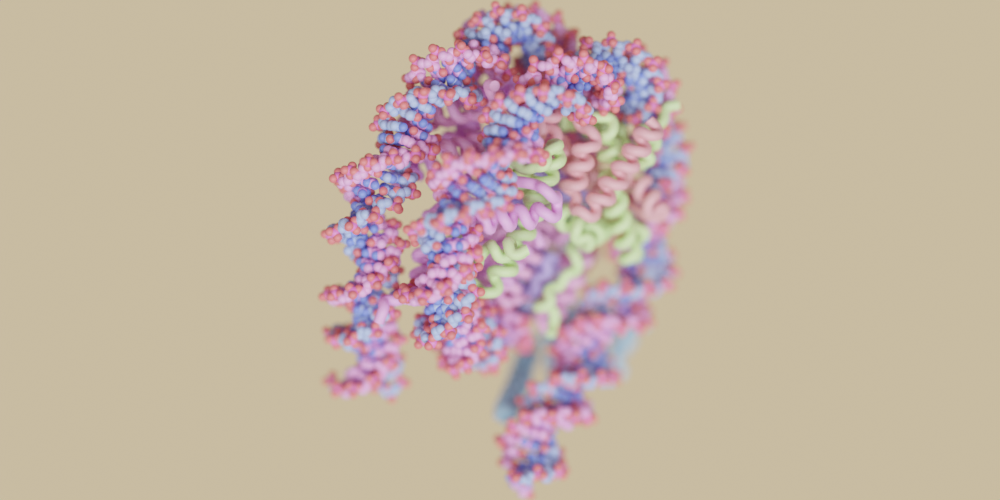

In [12]:
orient_camera(mol, f = 0.2)
render_image('cycles')

### Some more examples.

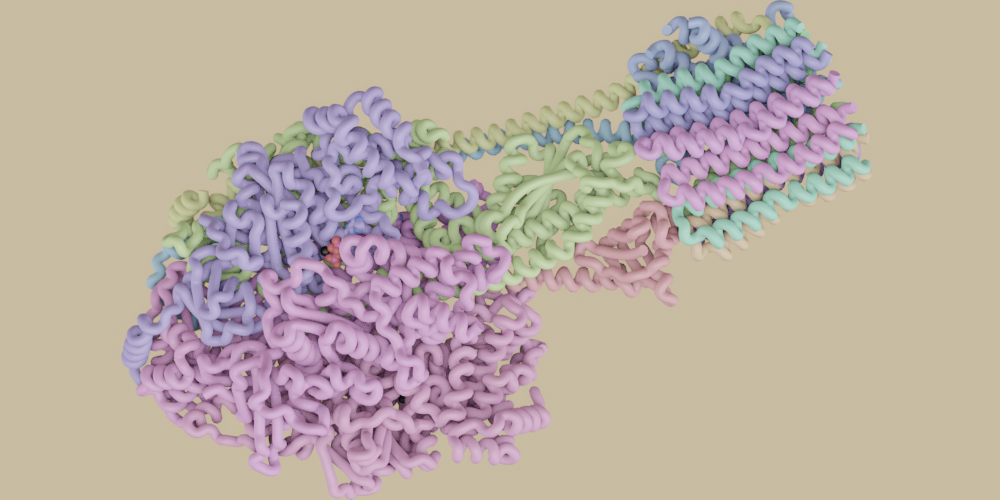

In [6]:
clear_scene()

mol = mn.load.molecule_rcsb('6N2Y', center_molecule=True, starting_style="preset_3")
mol.select_set(True)
mol.rotation_euler = (0, 90, 180)
orient_camera(mol)
render_image()

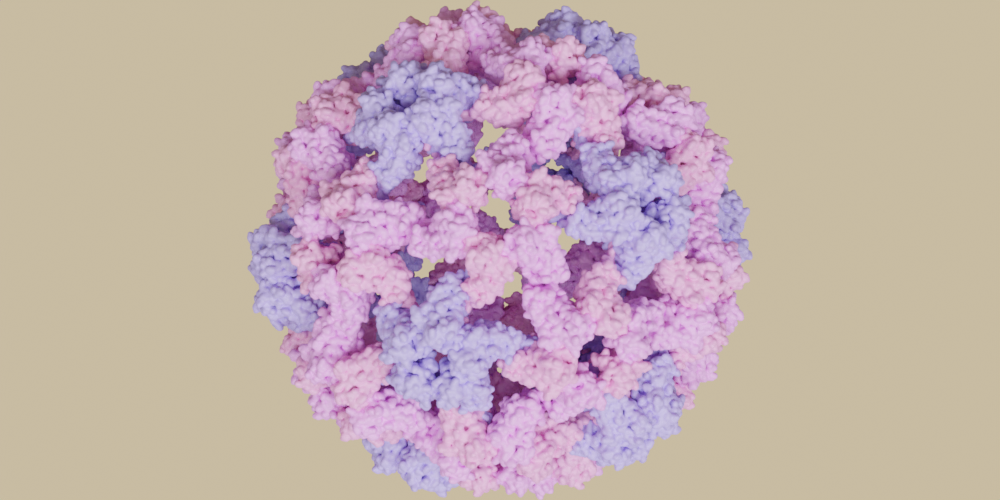

In [7]:
clear_scene()
mol = mn.load.molecule_rcsb('8CPY', build_assembly=True, starting_style="surface")
orient_camera(mol)
render_image('cycles')